# Financial Markets

This notebook belongs to the project of physics applied to social sciences of the S2 of ENSAE.

The choosen subject is "financial markets".

This notebook contains all the codes used for the project.

## First model

This is a very simple model that describes a financial market. This model is based on an evolution of the price of a stock as a result of the combination of a random variable and the strategy of the market's agents.

We focus on the change of the price of a stock between two periods t-1 and t. To do that we use a random variable that follows a guassian distribution with parameters $\sigma$ in order to estimate the price of the stock at date t. This simulates an evolution of the price between dates t-1 and t. Then, we study the strategy of every agent based on simulated informations. Finally, orders are passed and the stock price changes.

In [1]:
import random
import matplotlib.pyplot as plt


def calculate_return(x_t, x_t_minus_1):
    return (x_t - x_t_minus_1) / x_t_minus_1
    # calculates the return of a financial asset between two consecutive time periods.


def update_market_price(x_t_minus_1, e_t, gamma, mu):
    return x_t_minus_1 * (1 + gamma * e_t) ** mu
    # return the new price of the stock. This new price is determined randomly

def calculate_average_strategy(profit, num_agents):
    return profit / num_agents


def calculate_market_return(x_t, x_0):
    return (x_t - x_0) / x_0


def simulate_market(num_agents, num_rounds, gamma, mu, sigma, rand):
    """ Explanation of the variables : 
            num_agents = the number of agents on the market
            num_rounds = the number of days for which you want a simulation  
            gamma = an influence factor that measures the impact of agents' decisions on the market. A higher value of gamma means that agents' decisions have a greater effect on the market price.
            mu = a discount factor that measures the impact of changes on the market. A higher value of mu means that changes have a greater effect on the market price.
            sigma = the power of the variation of prices (the larger the sigma, the more likely it is that prices will vary) 
            rand = here in order to preserve the reproducibility   """
    #this function uses random number, thus to preserve the reproducibility :
    random.seed(rand)

    # Initialize the market with a random price
    x_t_minus_1 = random.uniform(90, 110) #90, 110
    x_0 = x_t_minus_1

    # Initialize each agent with an equal amount of cash
    c_i = 10000 / num_agents    # The quantity of cash that each agent has
    q_i = 0                     # The quantity of stock that each agent has

    # Initialize lists to store market price and market return
    market_prices = [x_t_minus_1]
    market_returns = [0]

    # Initialize lists to store each agent's profit and strategy
    agent_profits = [0] * num_agents      # The profit of each agent 
    agent_strategies = [0] * num_agents   # The strategie of each agent 

    for t in range(num_rounds):
        # Calculate the market return for the current time step
        market_return = calculate_market_return(x_t_minus_1, x_0) 
        market_returns.append(market_return)

        # Update the market price for the current time step
        e_t = random.gauss(0, sigma)                              # random gaussian distribution floating number following a Gaussian distribution with mean 0 and standard deviation sigma
        x_t = update_market_price(x_t_minus_1, e_t, gamma, mu)    
        market_prices.append(x_t)

        for i in range(num_agents):
            # Calculate the return on investment for agent i
            r_i = calculate_return(x_t, x_t_minus_1)

            # Calculate the profit and new quantity of stock for agent i
            p_i = q_i * r_i
            q_i = c_i / x_t

            # Update agent i's strategy
            agent_strategies[i] = (1 + gamma * r_i) * agent_strategies[i] + random.gauss(0, sigma)

            # Update agent i's profit
            agent_profits[i] += p_i

        # Calculate the average strategy for all agents
        average_strategy = calculate_average_strategy(sum(agent_strategies), num_agents)

        # Update the market price using the average strategy
        x_t = update_market_price(x_t_minus_1, average_strategy, gamma, mu)
        market_prices[-1] = x_t

        # Update x_t_minus_1 for the next time step
        x_t_minus_1 = x_t

    return market_prices, market_returns
    #The code returns market prices and returns over time



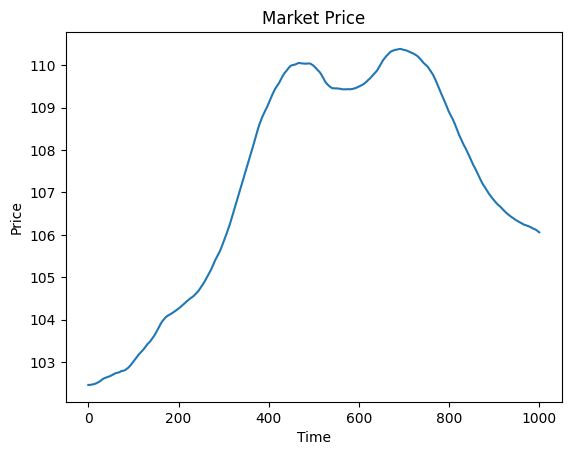

In [2]:
num_agents = 1000
num_rounds = 1000
gamma = 0.2
mu = 0.02
sigma = 0.1
rand = 5

market_prices, market_returns = simulate_market(num_agents, num_rounds, gamma, mu, sigma, rand)

plt.plot(market_prices)
plt.title('Market Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

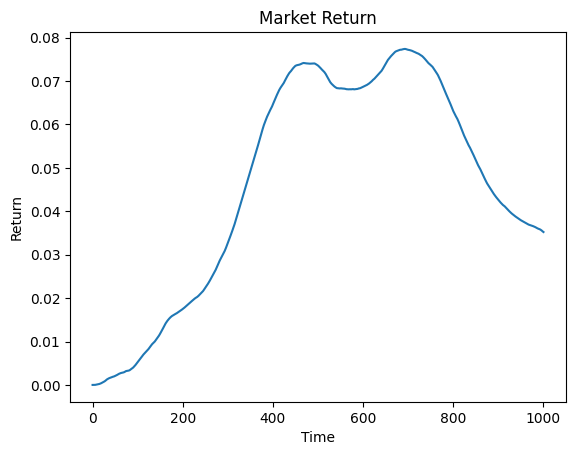

In [3]:
num_agents = 1000
num_rounds = 1000
gamma = 0.2
mu = 0.02
sigma = 0.1
rand = 5

market_prices, market_returns = simulate_market(num_agents, num_rounds, gamma, mu, sigma, rand)

plt.plot(market_returns)
plt.title('Market Return')
plt.xlabel('Time')
plt.ylabel('Return')
plt.show()

We will now make a step further and use models where the next price is not randomly attroibuted but the result of the Suplly/Demand law in the case of an inelastic offer (the number total of stock is detrmined and remain constant)

## The homogeneous investor model

In [4]:
"""import the package"""
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.optimize
from tqdm import tqdm

In this basic model every memory of return rate has the same weight and the utility function is $$U(W)= \log(W)$$
Also, evry agent has the same memory span.

In [5]:
class Market:

    def __init__(self, nb_agent = 100, nb_shares = 10000, interest_rate = 4/100, ini_price = 4, ini_dividend = 0.2, noise = False, noise_sdv=0.2, history_recall = 15):
        #will not be changed
        self.nb_agent = nb_agent #number of agent
        self.k = history_recall #history recall
        self.noise = noise 
        self.interest_rate = interest_rate #interest rate of the bond
        self.nb_shares = nb_shares #total number of shares

        #will be updated
        self.stock_price = ini_price #price of stock
        self.N = [0] * self.nb_agent #number of shares held by investors
        self.W = [1000] * self.nb_agent #wealth of investors (in USD)
        self.dividend = ini_dividend #dividend
        random.seed(5)
        self.stock_history = [random.gauss(4.15/100,0.3/100) for _ in range(self.k)] #initialisation of the stock return history
        self._seed = 0 #seed for further random assesment

        #initialize the noise :
        self.noise_sdv = noise_sdv
        self.noise_ =  [random.gauss(0,self.noise_sdv) for _ in range(self.nb_agent)]

    #compute the gains for every investor
    def income_gains(self):
        for i in range(self.nb_agent):
            self.W[i] += self.N[i]*self.dividend + (self.W[i]-self.N[i]*self.stock_price)*self.interest_rate
    
    #we will now update the price thanks to the offer/demand law
    #We will write various functions for the i-th investor and then make a "sweep" function that updates every invertors

    #compute an hypothetical wealth for every agent function of an hypothetical price
    def hypo_W(self, hypo_price, i):
        return self.W[i]+self.N[i]*self.dividend+(self.W[i] - self.N[i]*self.stock_price)*self.interest_rate+self.N[i]*(hypo_price-self.stock_price)
    
    #compute an expected utility for every agent and for a proportion invested in stock
    def expected_utility(self, W_h, prop):
        k = self.k
        r = self.interest_rate
        _tmp = [np.log((1-prop) * W_h*(1+r) + prop*W_h*(1+p)) if (1-prop) * W_h*(1+r) + prop*W_h*(1+p)>0 else np.nan for p in self.stock_history ]
        return 1/k * np.sum(_tmp)
    
    #compute the proportion invested in stock that maximizes the utility function of an agent as a result of an hypothetical price
    def X_hypo(self, i, hypo_price):
        W_h = self.hypo_W(hypo_price, i)
        result = scipy.optimize.minimize(lambda x: -self.expected_utility(W_h, x), bounds=[(0.01, 0.99)], x0= 0.01).x
    #As no borrowing or shortselling is allowed, we have 0 =< X =< 1 but to avoid the case where X = 1 (actually a human investor will never
    # invest all of his money in stocks (it will kepp some for emergency needs for example))
        if not self.noise:    
            return result
        elif result + self.noise_[i]>0.99:
            return result
        elif result + self.noise_[i]<0.01:
            return result
        else:
            return result + self.noise_[i]

    #aggregate all the individual demands
    def total_demand(self, hypo_price):
        Li = [0]*self.nb_agent
        for i in range(self.nb_agent):
            Li[i] = (self.X_hypo(i, hypo_price)*self.hypo_W(hypo_price, i))/hypo_price
        return np.sum(Li)
    
    #the following function is made to compute the new the stock price
    def update_stock_price(self):
        return scipy.optimize.root_scalar(lambda x: self.total_demand(x)-self.nb_shares, bracket=(1, 1e8)).root
        

    #the following function is made to update the history stock return
    def history_update(self, new_price):
        self.stock_history = self.stock_history[1:]
        _tmp = (new_price - self.stock_price + self.dividend)/self.stock_price
        self.stock_history.append(_tmp)



    #We are about to write the most important funtion of the code :
    def update(self):
        self.income_gains() #update the gains (earn dividends and interest of the bond)
        new_stock_price = self.update_stock_price() #compute the new stock price as a result of Supply/demand law
        for i in range(self.nb_agent):
            self.W[i] += self.N[i]*(new_stock_price-self.stock_price) #update the wealth
            self.N[i] = self.X_hypo(i, new_stock_price)*self.W[i]/new_stock_price #update the number of stock
        self.dividend *= 1.05 #update the dividend
        self.history_update(new_stock_price) #update the history rate of return
        self.stock_price = new_stock_price #update the stock price
        if self.noise:
            random.seed(self._seed)
            self.noise_ = [random.gauss(0,self.noise_sdv) for _ in range(self.nb_agent)] #change the noise
            self._seed += 1
            


In [6]:
def simulation(market, nb_iter):
    Li = [market.stock_price]
    for i in tqdm(range(nb_iter)):
        market.update()
        Li.append(market.stock_price)
    return Li

In [7]:
nb_rounds = 100

nb_agent = 100
nb_shares = 10000
interest_rate = 4/100
ini_price = 4
ini_dividend = 0.2
noise = False
noise_sdv=0.2
history_recall = 15


market = Market(nb_agent, nb_shares, interest_rate, ini_price, ini_dividend, noise, noise_sdv, history_recall)


X = list(range(nb_rounds+1))
Y = simulation(market, nb_rounds)

plt.plot(X, Y)
plt.xlabel("Time")
plt.ylabel("Stock price ($)")
plt.title('Stock price with no noise, memory span $k=15$ and $U = \log$')
plt.yscale('log')
plt.show()

  0%|          | 0/100 [00:03<?, ?it/s]


KeyboardInterrupt: 

100%|██████████| 100/100 [10:50<00:00,  6.50s/it]


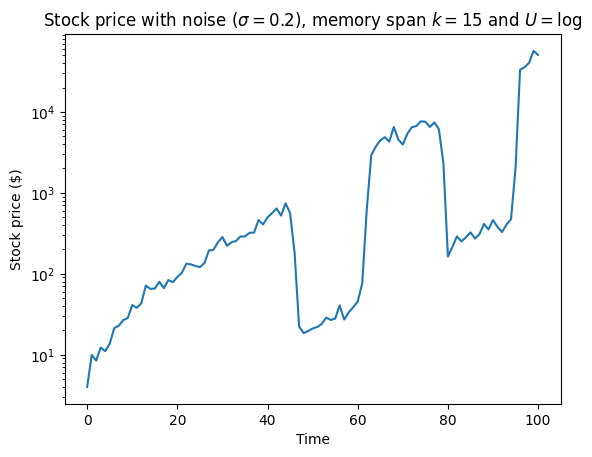

In [19]:
nb_rounds = 100

nb_agent = 100
nb_shares = 10000
interest_rate = 4/100
ini_price = 4
ini_dividend = 0.2
noise = True
noise_sdv=0.2
history_recall = 15


market = Market(nb_agent, nb_shares, interest_rate, ini_price, ini_dividend, noise, noise_sdv, history_recall)


X = list(range(nb_rounds+1))
Y = simulation(market, nb_rounds)

plt.plot(X, Y)
plt.xlabel("Time")
plt.ylabel("Stock price ($)")
plt.title('Stock price with noise ($\sigma = 0.2$), memory span $k=15$ and $U = \log$')
plt.yscale('log')
plt.show()

# Heterogeneous Investor Models

In order to make a models that takes into account the diversity of investors we will focus on two major points :

Fisrtly, we study the case where investors differ in their expectations. To be more specific we change (for some investors) the memory span ($k$).

Secondly we tackle the diversity in the preferences :
We give to every investor the following utility function : 
$$ U_i(W) = \frac{W^{1-\alpha_i}}{1-\alpha_i}$$
where $\alpha_i$ is a measure of the risk aversion.



In [8]:
class Market_2(Market):

    def __init__(self, nb_agent = 100, nb_shares = 10000, history_recall = 15, interest_rate = 4/100, ini_price = 4, ini_dividend = 0.2, noise = False, noise_sdv = 0.2):
        #we are just adding the alpha for each investor
        super().__init__(nb_agent, nb_shares, interest_rate, ini_price, ini_dividend, noise, noise_sdv, history_recall)
        self.alpha = [0.5 for _ in range(int(self.nb_agent/2))]+[3.5 for _ in range(int(self.nb_agent/2))] #initialize the risk aversion

    #compute the utility, depends of the agent (and thus his/her risk aversion)
    def _utility(self, x, i):
        return x**(1-self.alpha[i])/1-self.alpha[i]
    
    #compute the expected utility (method overriding)
    def expected_utility(self, W_h, prop, i):
        k = self.k
        r = self.interest_rate
        _tmp = [self._utility((1-prop) * W_h*(1+r) + prop*W_h*(1+p), i) if (1-prop) * W_h*(1+r) + prop*W_h*(1+p)>0 else np.nan for p in self.stock_history ]
        return 1/k * np.sum(_tmp)
    
    #compute the proportion of invested stock that maximizes utility for each agent function of an hypothetical price (method overriding)
    def X_hypo(self, i, hypo_price):
        W_h = self.hypo_W(hypo_price, i)
        result = scipy.optimize.minimize(lambda x: -self.expected_utility(W_h, x, i), bounds=[(0.01, 0.99)], x0= 0.01).x
    #As no borrowing or shortselling is allowed, we have 0 =< X =< 1 but to avoid the case where X = 1 (actually a human investor will never
    # invest all of his money in stocks (it will kepp some for emergency needs for example))
        if not self.noise:    
            return result
        elif result + self.noise_[i]>0.99:
            return result
        elif result + self.noise_[i]<0.01:
            return result
        else:
            return result + self.noise_[i]

100%|██████████| 100/100 [06:49<00:00,  4.10s/it]


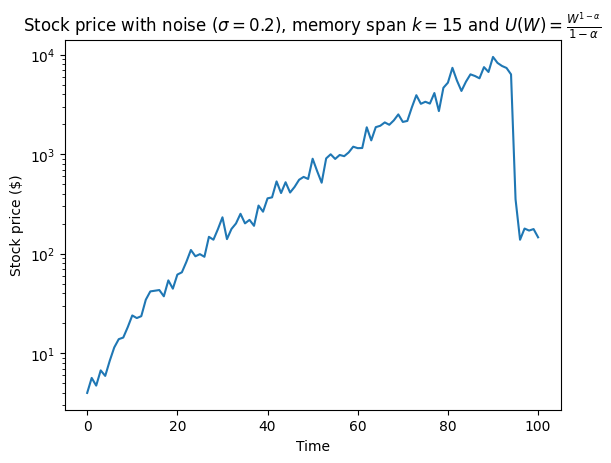

In [21]:
nb_rounds = 100

nb_agent = 100
nb_shares = 10000
history_recall = 15
interest_rate = 4/100
ini_price = 4
ini_dividend = 0.2
noise = True
noise_sdv = 0.2


market = Market_2(nb_agent, nb_shares, history_recall, interest_rate, ini_price, ini_dividend, noise, noise_sdv)

X = list(range(nb_rounds+1))
Y = simulation(market, nb_rounds)

plt.plot(X, Y)
plt.xlabel("Time")
plt.ylabel("Stock price ($)")
plt.title(r'Stock price with noise ($\sigma = 0.2$), memory span $k=15$ and $U(W) = \frac{W^{1-\alpha}}{1-\alpha}$')
plt.yscale('log')
plt.show()

# Final model

At this point of the project we have a model where :
- The memory span is uniform and constant
- The choosen proportion of stock to buy is noised (as an option) (gaussian mean 0 and sdv as a parameter)
- The risk aversion is semi determinist : we slice the population into 2 groups each has a risk aversion uniform and constant (in the previous code the values are fixed : 0.5 and 3.5)

And (even if we will keep this hypothesis) every value of the history return is treated the same (see $1/k$ factor)

Then, in this last model we will build another inherited class "Market_3" in order to fully randomise the model :

To be more specific, the memory span choosen won't be uniform anymore but will remain constant.  
And we will do the same for the risk aversion

In [9]:
class Market_3(Market):

    def __init__(self, nb_agent = 100, nb_shares = 10000, interest_rate = 4/100, ini_price = 4, ini_dividend = 0.2, noise = True, noise_sdv = 0.2, alpha_range = [0, 4], history_range = [1, 20]):
        super().__init__(nb_agent, nb_shares, interest_rate, ini_price, ini_dividend, noise, noise_sdv, history_range[1])
        random.seed(5)
        self.alpha = [random.uniform(alpha_range[0], alpha_range[1]) for _ in range(nb_agent)] #initialize the risk aversion
        self.history_recall = [int(random.uniform(history_range[0], history_range[1])) for _ in range(nb_agent)] #new k_i : memory span for each agent
        self.stock_history = [self.stock_history[len(self.stock_history)-i:] for i in self.history_recall] #initialze the history rate of return of the stock depending of the memory span of each agent
        
    #compute the utility of each agent
    def _utility(self, x, i):
        return x**(1-self.alpha[i])/1-self.alpha[i]
    
    #compute th eexpected utility of each agent (method overriding)
    def expected_utility(self, W_h, prop, i):
        k = self.history_recall[i]
        r = self.interest_rate
        _tmp = [self._utility((1-prop) * W_h*(1+r) + prop*W_h*(1+p), i) if (1-prop) * W_h*(1+r) + prop*W_h*(1+p)>0 else np.nan for p in self.stock_history[i]]
        return 1/k * np.sum(_tmp)
    
    #compute the proportion of stock invested money that maximizes the utility of every agent (method overriding)
    def X_hypo(self, i, hypo_price):
        W_h = self.hypo_W(hypo_price, i)
        result = scipy.optimize.minimize(lambda x: -self.expected_utility(W_h, x, i), bounds=[(0.01, 0.99)], x0= 0.01).x
    #As no borrowing or shortselling is allowed, we have 0 =< X =< 1 but to avoid the case where X = 1 (actually a human investor will never
    # invest all of his money in stocks (it will kepp some for emergency needs for example))
        if not self.noise:    
            return result
        elif result + self.noise_[i]>0.99:
            return result
        elif result + self.noise_[i]<0.01:
            return result
        else:
            return result + self.noise_[i]
        
    #new history update that takes into account the fact that each agent has a proper memory span (method overriding)
    def history_update(self, new_price, i):
        self.stock_history[i] = (self.stock_history[i])[1:]
        _tmp = (new_price - self.stock_price + self.dividend)/self.stock_price
        self.stock_history[i].append(_tmp)

    #new update function in order to also update the history rate of return (method overriding)
    def update(self):
        self.income_gains()
        new_stock_price = self.update_stock_price()
        for i in range(self.nb_agent):
            self.W[i] += self.N[i]*(new_stock_price-self.stock_price)
            self.N[i] = self.X_hypo(i, new_stock_price)*self.W[i]/new_stock_price
        self.dividend *= 1.05
        for i in range(self.nb_agent):
            self.history_update(new_stock_price, i)
        self.stock_price = new_stock_price
        if self.noise:
            random.seed(self._seed)
            self.noise_ = [random.gauss(0,self.noise_sdv) for _ in range(self.nb_agent)]
            self._seed += 1

100%|██████████| 200/200 [18:35<00:00,  5.58s/it]


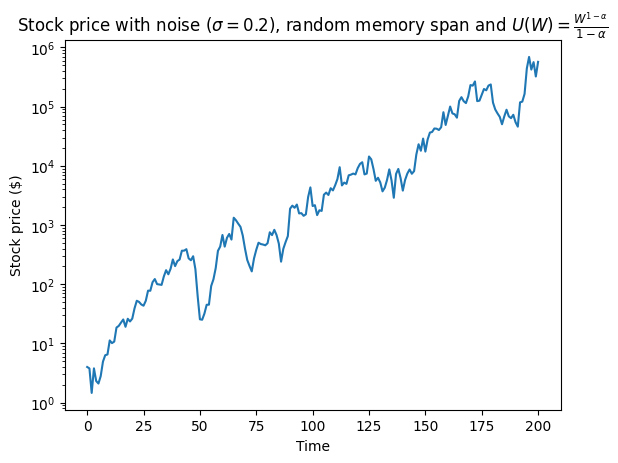

In [10]:
nb_rounds = 200

nb_agent = 100
nb_shares = 10000
interest_rate = 4/100
ini_price = 4
ini_dividend = 0.2
noise = True
noise_sdv = 0.2
alpha_range = [0, 4]
history_range = [1, 20]

market = Market_3(nb_agent, nb_shares, interest_rate, ini_price, ini_dividend, noise, noise_sdv, alpha_range, history_range)

X = list(range(nb_rounds+1))
Y = simulation(market, nb_rounds)

plt.plot(X, Y)
plt.xlabel("Time")
plt.ylabel("Stock price ($)")
plt.title(r'Stock price with noise ($\sigma = 0.2$), random memory span and $U(W) = \frac{W^{1-\alpha}}{1-\alpha}$')
plt.yscale('log')
plt.show()